## PROYECTO IMAGENES

### IMPORT

In [13]:
from skimage.feature import hog
from skimage.io import imread
#libreria para CNN
from deepface import DeepFace
import os
import pandas as pd
from scipy.spatial.distance import euclidean, cosine
import numpy as np

Se implementan 3 niveles de extracción de características

### Handcrafted Method

In [14]:
def  handcrafted_method(path,orientations=9,pixels_per_cell=(8, 8),cells_per_block=(2, 2)):
 img = imread(path)
 fd, hog_image = hog(img, orientations, pixels_per_cell,
                     cells_per_block, block_norm='L2-Hys',
                     visualize=True, channel_axis=-1)
 print(fd)
 return fd

### Nivel 2. Convolutional Neural Networks.

### Nivel 3. Modelos de reconocimiento de rostros.

In [15]:
def extract_deepface_features(image_path):
    embedding = DeepFace.represent(img_path=image_path, model_name="Facenet")  # O el modelo que elijas
    return embedding

### Preparación de la base de datos

Se tiene una selección de la base de datos VGGfaces2, con 11 imagenes de 496 sujetos. De cada sujeto, se 
escoge solo una como imagen de consulta (img_query). El resto se integrará a la base de datos

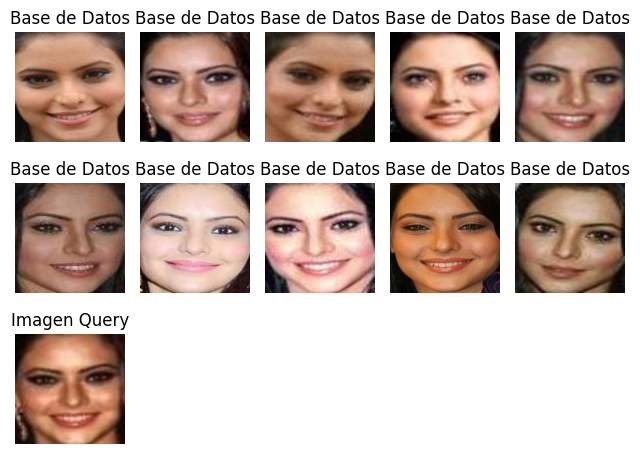

In [29]:
import os
import cv2
import matplotlib.pyplot as plt

# Especifica la ruta a la carpeta donde están las imágenes
ruta_carpeta = 'CBIR Faces Dataset 2024/n000011'

# Obtiene la lista de archivos en la carpeta
archivos_imagenes = sorted([f for f in os.listdir(ruta_carpeta) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Carga y muestra las primeras 10 imágenes de la base de datos y la imagen 11 como 'Imagen Query'
for i in range(11):
    img_path = os.path.join(ruta_carpeta, archivos_imagenes[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convierte de BGR a RGB para que se muestre correctamente con matplotlib
    
    plt.subplot(3, 5, i + 1)  # Subplot de 3 filas x 4 columnas
    plt.imshow(img)
    plt.axis('off')
    
    # Etiquetado
    if i < 10:
        plt.title('Base de Datos')
    else:
        plt.title('Imagen Query')

plt.tight_layout()
plt.show()


### Cálculo del vector de características.
Se implemeta una funcion que calcula el vector de caracterisiticas de una imagen. Esta funcion recive la imagen y el nivel de extracción. 

Tambien se implementa se calculan y guardan las caracteristicas de cada imagen de la base. Estas son guardadas en un arvhivo csv.

In [17]:
def calcular_vector_caracteristicas(ruta_imagen, nivel):
    if nivel == 1:
        result = handcrafted_method(ruta_imagen)
        #return hist
    elif nivel == 2:
        pass  # Agregar lógica para nivel 2
    elif nivel == 3:
        result = extract_deepface_features(ruta_imagen|):
        
        # El resultado es una lista de diccionarios, seleccionamos solo el embedding
        if result and 'embedding' in result[0]:
            embedding = result[0]['embedding']
            return embedding
        

def guardar_en_csv(nombre_imagen, vector_caracteristicas, csv_writer):
    fila = [nombre_imagen] + vector_caracteristicas
    csv_writer.writerow(fila)

#Función principal para procesar las imágenes
def procesar_imagenes(nivel, dataset_path='CBIR Faces Dataset 2024'):
    output_path=f'nivel_{nivel}_base_de_datos'
    # Recorrer las carpetas del dataset
    for carpeta in os.listdir(dataset_path):
        carpeta_original = os.path.join(dataset_path, carpeta)
        if os.path.isdir(carpeta_original):
            # Crear la carpeta destino
            carpeta_destino = os.path.join(output_path, 'img_database', carpeta)
            os.makedirs(carpeta_destino, exist_ok=True)

            # Crear el archivo CSV dentro de la carpeta correspondiente
            csv_path = os.path.join(carpeta_destino, f'{carpeta}.csv')
            with open(csv_path, mode='w', newline='') as csv_file:
                csv_writer = csv.writer(csv_file)
                # Escribir encabezado
                encabezado = ['imagen'] + [f'caracteristica_{i+1}' for i in range(26244)]  # Ajustar según el número de características
                csv_writer.writerow(encabezado)

                # Generar los nombres de las primeras 10 imágenes
                for i in range(1, 11):  # Iterar del 1 al 10
                    imagen_nombre = f'{carpeta}_{i}.jpg'
                    ruta_imagen = os.path.join(carpeta_original, imagen_nombre)

                    # Comprobar si la imagen existe
                    if not os.path.exists(ruta_imagen):
                        print(f"Imagen no encontrada: {ruta_imagen}")
                        continue

                    # Calcular el vector de características
                    vector = calcular_vector_caracteristicas(ruta_imagen, nivel)

                    # Guardar el vector de características en el archivo CSV dentro de la carpeta correspondiente
                    guardar_en_csv(imagen_nombre, vector, csv_writer)

# Llamar a la función para procesar las imágenes con el nivel deseado
procesar_imagenes(nivel=3)


SyntaxError: invalid syntax (1764868475.py, line 8)

# Esquema de comparacion
Se crea una funcion que determine la distancia entre la imagen de consulta y todas las imagenes de la base de datos.

se comprueban distintas distancias por ejemplo la euclidiana, la distancia coseno, chi–cuadrado y ...

In [18]:
# Función para calcular la similitud entre dos vectores
def calcular_similitud(query_vector, vector, metric='euclidean'):
    if metric == 'euclidean':
        dist = euclidean(query_vector, vector)
    elif metric == 'cosine':
        dist = cosine(query_vector, vector)
    return dist

Buscar las 10 mejores imagenes dentro de todo el data set

In [44]:
import os
import pandas as pd
from deepface import DeepFace
from scipy.spatial.distance import euclidean, cosine
import numpy as np

# Función para extraer el vector de características de una imagen de consulta usando DeepFace
def calcular_vector_caracteristicas_deepface(imagen_path, modelo='VGG-Face'):
    embedding = DeepFace.represent(img_path=imagen_path, model_name=modelo)
    return np.array(embedding[0]["embedding"])

# Función para calcular la similitud entre dos vectores
def calcular_similitud(query_vector, vector, metric='euclidean'):
    if metric == 'euclidean':
        dist = euclidean(query_vector, vector)
    elif metric == 'cosine':
        dist = cosine(query_vector, vector)
    return dist

# Función para cargar datos y etiquetas de un archivo CSV
def cargar_data(file_path):
    label_array = []  
    vector_array = []

    # Cargar el archivo CSV, omitiendo la primera fila (títulos)
    df = pd.read_csv(file_path, skiprows=1, header=None)
    for i in range(10):
        fila = df.iloc[i].tolist()[1:]
        label = df.iloc[i].tolist()[0]
        label_array.append(label)  # Agregar etiqueta a la lista
        vector_array.append(fila) 

    label_array = np.array(label_array, dtype=str) 
    vector_array = np.array(vector_array, dtype=float)
    
    return label_array, vector_array

# Función para calcular y mostrar distancias junto con las etiquetas
def distancia_persona(query_vector, folder_path_base, start=1, end=500):
    todas_similitudes = []

    for i in range(start, end + 1):
        folder_name = f"n{i:06d}"  # Formatear el número de carpeta
        file_path = os.path.join(folder_path_base, folder_name, f"{folder_name}.csv")
        
        # Verificar si el archivo CSV existe en la carpeta
        if os.path.exists(file_path):
            labels, vectors = cargar_data(file_path)
            for j in range(len(vectors)):
                dist = calcular_similitud(query_vector, vectors[j])
                todas_similitudes.append((labels[j], dist, file_path))  # Guardar etiqueta, distancia y ruta

    # Crear un DataFrame con todas las distancias
    df_similitudes = pd.DataFrame(todas_similitudes, columns=["Label", "Distance", "File Path"])

    # Ordenar por distancia y seleccionar las 10 menores distancias
    df_mejores = df_similitudes.sort_values(by="Distance").head(10)
    
    return df_mejores

# Ejemplo de uso
folder_path_base = "nivel_3_base_de_datos/img_database"  # Ruta base de la carpeta
vector_query = calcular_vector_caracteristicas_deepface("CBIR Faces Dataset 2024/n000011/n000011_11.jpg")

# Mostrar las 10 mejores coincidencias con distancias más pequeñas
df_resultado = distancia_persona(vector_query, folder_path_base)
print(df_resultado)


               Label  Distance  \
100    n000011_1.jpg  0.656116   
106    n000011_7.jpg  0.830825   
101    n000011_2.jpg  0.863778   
107    n000011_8.jpg  0.933583   
102    n000011_3.jpg  0.966736   
104    n000011_5.jpg  0.975068   
109   n000011_10.jpg  0.985388   
105    n000011_6.jpg  0.992836   
103    n000011_4.jpg  1.044876   
3161   n000320_2.jpg  1.057405   

                                              File Path  
100   nivel_3_base_de_datos/img_database\n000011\n00...  
106   nivel_3_base_de_datos/img_database\n000011\n00...  
101   nivel_3_base_de_datos/img_database\n000011\n00...  
107   nivel_3_base_de_datos/img_database\n000011\n00...  
102   nivel_3_base_de_datos/img_database\n000011\n00...  
104   nivel_3_base_de_datos/img_database\n000011\n00...  
109   nivel_3_base_de_datos/img_database\n000011\n00...  
105   nivel_3_base_de_datos/img_database\n000011\n00...  
103   nivel_3_base_de_datos/img_database\n000011\n00...  
3161  nivel_3_base_de_datos/img_database\n000

Ejemplo de Busqueda

In [43]:
# Función para extraer el vector de características de una imagen de consulta usando DeepFace
def calcular_vector_caracteristicas_deepface(imagen_path, modelo='VGG-Face'):
    embedding = DeepFace.represent(img_path=imagen_path, model_name=modelo)
    return np.array(embedding[0]["embedding"])

# Ejemplo de uso
folder_path_base = "nivel_3_base_de_datos/img_database"  # Ruta base de la carpeta
vector_query = calcular_vector_caracteristicas_deepface("CBIR Faces Dataset 2024/n000011/n000011_11.jpg")

# Mostrar las 10 mejores coincidencias con distancias más pequeñas
df_resultado = distancia_persona(vector_query, folder_path_base)


# RANK

In [39]:
import pandas as pd

def calcular_rank(resultados, clase_consulta):
    """
    Calcula el ranking promedio para las imágenes relevantes de una clase de consulta específica.

    Parámetros:
    - resultados: DataFrame con columnas ["Label", "Distance"] ordenado por distancia.
    - clase_consulta: Clase de la imagen de consulta para identificar imágenes relevantes.

    Retorno:
    - rank: Valor de ranking promedio de las imágenes relevantes.
    """
    # Encontrar las posiciones de las imágenes relevantes (misma clase que la imagen de consulta)
    posiciones_relevantes = [
        index + 1 for index, label in enumerate(resultados["Label"]) if clase_consulta in label
    ]

    print(posiciones_relevantes)
    # Número de imágenes relevantes
    n_relevantes = len(posiciones_relevantes)

    # Calcular el Rank si hay imágenes relevantes
    if n_relevantes > 0:
        rank = sum(posiciones_relevantes) / n_relevantes
    else:
        rank = None  # Si no hay imágenes relevantes, devolvemos None o 0 según lo deseado

    return rank

# Ejemplo de uso
# Supón que `df_resultado` es el DataFrame ordenado de etiquetas y distancias para una imagen de consulta
# y que la clase de la imagen de consulta es "n000011".

clase_consulta = "n000011"
rank_promedio = calcular_rank(df_resultado, clase_consulta)
print("Ranking promedio de imágenes relevantes:", rank_promedio)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 15]
Ranking promedio de imágenes relevantes: 6.0


# Rank Normalizado

In [40]:
def calcular_rank_normalizado(resultados, clase_consulta):
    """
    Calcula el Rank Normalizado para evaluar el rendimiento de un método de recuperación de imágenes.

    Parámetros:
    - resultados: DataFrame con columnas ["Label", "Distance"] ordenado por distancia.
    - clase_consulta: Clase de la imagen de consulta para identificar imágenes relevantes.

    Retorno:
    - rank_normalizado: Valor del Rank Normalizado para la consulta.
    """
    # Número total de imágenes en el conjunto
    N = len(resultados)

    # Encontrar las posiciones de todas las imágenes relevantes (de la misma clase que la consulta)
    posiciones_relevantes = [
        index + 1 for index, label in enumerate(resultados["Label"]) if clase_consulta in label
    ]
    
    # Número de imágenes relevantes
    Nrel = len(posiciones_relevantes)
     # Calcular el Rank Normalizado
    if Nrel > 0:
        sum_Ri = sum(posiciones_relevantes)
        rank_normalizado = (1 / (N * Nrel)) * (sum_Ri - (Nrel * (Nrel + 1)) / 2)
    else:
        rank_normalizado = None  # Devuelve None si no hay imágenes relevantes

    return rank_normalizado


clase_consulta = "n000011"
rank_promedio = calcular_rank_normalizado(df_resultado, clase_consulta)
print("Ranking promedio de imágenes relevantes:", rank_promedio)

Ranking promedio de imágenes relevantes: 0.01


# Resultados

Resultados cualitativos para los 5 primeros resultados:


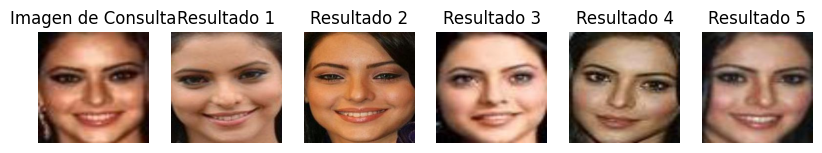

Resultados cualitativos para los 10 primeros resultados:


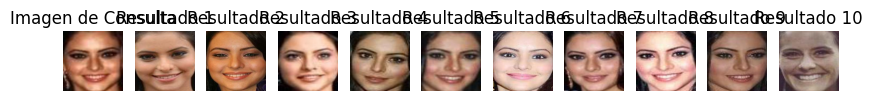

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

# Ruta base de la carpeta donde se encuentran las imágenes
base_path = "CBIR Faces Dataset 2024"

# Función para cargar y mostrar una imagen
def mostrar_imagen(img_label, title=""):
    # Construir la ruta de la imagen basada en el label
    folder_name = img_label.split('_')[0]  # Extrae la carpeta (n000xxx) del label
    img_path = os.path.join(base_path, folder_name, img_label)
    
    # Cargar la imagen
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    else:
        print(f"Error: No se pudo cargar la imagen en {img_path}")

# Función para mostrar resultados de búsqueda
def mostrar_resultados(resultados, consulta_label, num_resultados=5):
    """
    Muestra los resultados de búsqueda de una consulta de imagen.
    
    Parámetros:
    - resultados: DataFrame con columnas ["Label", "Distance"] ordenado por relevancia.
    - consulta_label: Etiqueta de la imagen de consulta (ej. "n000011_1.jpg").
    - num_resultados: Número de primeros resultados a mostrar (5 o 10).
    """
    # Mostrar imagen de consulta
    plt.figure(figsize=(10, 5))
    plt.subplot(1, num_resultados + 1, 1)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title("Imagen de Consulta")
        plt.axis('off')
    
    # Mostrar los primeros `num_resultados` resultados en orden de relevancia
    for i in range(num_resultados):
        img_label = resultados.iloc[i]["Label"]
        plt.subplot(1, num_resultados + 1, i + 2)
        mostrar_imagen(img_label, title=f"Resultado {i + 1}")

    plt.show()


    # Ruta de la imagen de consulta
consulta_path = "_11.jpg"

# Mostrar los 5 primeros resultados
print("Resultados cualitativos para los 5 primeros resultados:")
mostrar_resultados(df_resultado, consulta_path, num_resultados=5)

# Mostrar los 10 primeros resultados
print("Resultados cualitativos para los 10 primeros resultados:")
mostrar_resultados(df_resultado, consulta_path, num_resultados=10)